In [1]:
import math
import sklearn.metrics.pairwise as sk
from cvxopt import matrix, solvers
import os
import sys
import time
import shutil
import logging
import argparse
import yaml
import traceback

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
solvers.options['show_progress'] = False

In [2]:
pwd

'/atlas/u/madeline/f-dre/notebooks'

In [3]:
cd ../src

/atlas/u/madeline/f-dre/src


In [4]:
from flows.models.maf import MAF
import torch
from sklearn.linear_model import LogisticRegression

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

%matplotlib inline
%load_ext autoreload
%autoreload 2

# 1) Dataset loading (run either (i) or (ii) -- not both)

## (i) EITHER: Load existing data from repo

In [1]:
# # Source data + labels
# X = np.load('../data/kmm-kliep/X.npy')
# y = np.load('../data/kmm-kliep/y.npy')
# # Target data + labels
# Z = np.load('../data/kmm-kliep/Z.npy') 
# u = np.load('../data/kmm-kliep/u.npy')
# # Additional set of target data + labels (not seen during train time)
# Z_test = np.load('../data/kmm-kliep/Z_test.npy')
# u_test = np.load('../data/kmm-kliep/u_test.npy')

## (ii) OR: Generate new data

In [25]:
import numpy.random as rnd
"""Generate synthetic data set"""

# Sample sizes
N = 1000
M = 1000

# Class properties
labels = [0, 1]
nK = 2

# Dimensionality
D = 2

# p = source dist, q = target dist
p = np.random.randn(N,2)
q = np.random.randn(M,2) + 3

# Create source/target dataset splits
split = int(N * .1)

# Source dataset
X = np.vstack([
    q[0:split],
    p[split:]
])
y = np.hstack([
    np.ones(split),
    np.zeros(N - split)
])

# Target dataset
Z = np.vstack([
    q[split:],
    p[0:split]
])
u = np.hstack([
    np.ones(N - split),
    np.zeros(split)
])

# Additional test target dataset (unseen at training time)
Z_test = np.vstack([
    np.random.randn(990,2) + 3,
    np.random.randn(10,2)
])
u_test = np.hstack([
    np.ones(990),
    np.zeros(10)
])

## 1.1) Visualize source & target domains

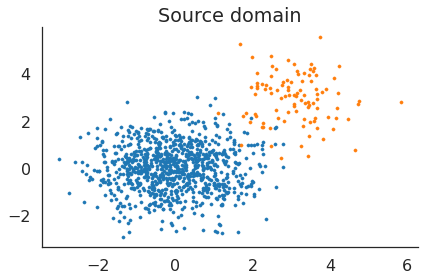

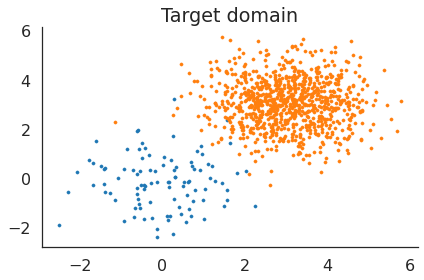

In [26]:
plt.scatter(X[:,0][y==0], X[:,1][y==0], s=10)
plt.scatter(X[:,0][y==1], X[:,1][y==1], s=10)

plt.title('Source domain')
sns.despine()
plt.tight_layout()

plt.figure(0)

plt.scatter(Z[:,0][u==0], Z[:,1][u==0], s=10)
plt.scatter(Z[:,0][u==1], Z[:,1][u==1], s=10)

plt.title('Target domain')
sns.despine()
plt.tight_layout()

# 2) Load flow

In [19]:
def load_flow(restore_file):
    model = MAF(5, 
                2, 
                100, 
                1, 
                None, 
                'relu', 
                'sequential', 
                batch_norm=True)
    state = torch.load(os.path.join(restore_file, "model_checkpoint.pt"), map_location=device)
    model.load_state_dict(state['model_state'])
    model = model.to(device)
    model.eval()
    return model

In [20]:
device = 'cpu'
restore_dir= 'flows/results/kmm_kliep_synthetic_maf'
flow = load_flow(restore_dir)

# 3) Encode data using flow & visualize

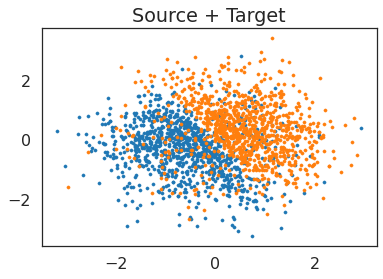

In [27]:
flow_X, _ = flow.forward(torch.from_numpy(X).cpu().float())
flow_Z, _ = flow.forward(torch.from_numpy(Z).cpu().float())
plt.clf()
plt.scatter(flow_X[:,0].data.cpu().numpy(), flow_X[:,1].data.cpu().numpy(), s=10)
plt.scatter(flow_Z[:,0].data.cpu().numpy(), flow_Z[:,1].data.cpu().numpy(), s=10)

plt.title('Source + Target')
plt.show()

# 4) Define KMM function

In [12]:
def kmm(Xtrain, Xtest, sigma, B):
    n_tr = len(Xtrain)
    n_te = len(Xtest)

    # calculate kernel
    K_ns = sk.rbf_kernel(Xtrain, Xtrain, sigma)
    K = np.array(K_ns)
    
    # calculate kappa
    kappa_r = sk.rbf_kernel(Xtrain, Xtest, sigma)
    kappa = np.sum(np.array(kappa_r), axis=1)
    kappa = -(float(n_tr) / float(n_te)) * kappa

    # calculate eps
    eps = (math.sqrt(n_tr) - 1) / math.sqrt(n_tr)

    # constraints
    A0 = np.ones(shape=(1, n_tr))
    A1 = -np.ones(shape=(1, n_tr))
    A = np.vstack([A0, A1, -np.eye(n_tr), np.eye(n_tr)])
    b = np.array([[n_tr * (eps + 1), n_tr * (eps - 1)]])
    b = np.vstack([b.T, np.zeros(shape=(n_tr, 1)), np.ones(shape=(n_tr, 1)) * B])

    P = matrix(K, tc='d')
    q = matrix(kappa, tc='d')
    G = matrix(A, tc='d')
    h = matrix(b, tc='d')
    beta = solvers.qp(P, q, G, h)
    return [i for i in beta['x']]

# 5) Fit classifiers

## 5.1) Baseline classifier (unweighted)

In [31]:
baseline_clf = LogisticRegression()
baseline_clf.fit(X, y)

baseline_preds = baseline_clf.predict(Z)
baseline_preds_unseen = baseline_clf.predict(Z_test)

baseline_err = np.mean(baseline_preds != u, axis=0)
baseline_err_unseen = np.mean(baseline_preds_unseen != u_test, axis=0)

# note that baseline classifier actually doesn't see either Z or Z_test during fitting
print('Baseline test error on seen target dataset: ', baseline_err)
print('Baseline unseen test error: ', baseline_err_unseen)

Baseline test error on seen target dataset:  0.049
Baseline unseen test error:  0.073


## 5.2) DRE classifiers (reweighted)

In [28]:
# Parameters to sweep over -- in paper we did sigmas = [0.01, 0.1, 0.5, 1.0] and Bs = [1, 10, 100, 1000]
# Here we only pick the best combination of (sigma, B) for conciseness
sigmas = [1.0]
Bs = [1000]

### 5.2.1) X-DRE classifier

In [32]:
best_x_sigma = 0
best_x_B = 0
best_x_err = float('inf')
best_x_unseen_err = float('inf')

for sigma in sigmas:
    print(f'sigma={sigma}')
    for B in Bs:
        print(f'B={B}')

        x_dre_clf = LogisticRegression()
        x_weights = kmm(X, Z, sigma, B)
        x_dre_clf.fit(X, y, sample_weight=x_weights)
        
        x_preds = x_dre_clf.predict(Z)
        x_err = np.mean(x_preds != u, axis=0)

        x_unseen_preds = x_dre_clf.predict(Z_test)
        x_unseen_err = np.mean(x_unseen_preds != u_test, axis=0)
            
        if x_err < best_x_err:
            best_x_err = x_err
            best_x_sigma = sigma
            best_x_B = B
            best_x_unseen_err = x_unseen_err
print(50*'=')
print('Best test error on seen target dataset: ', best_x_err)
print('Unseen test error: ', best_x_unseen_err)
print('Sigma: ', best_x_sigma)
print('B: ', best_x_B)

sigma=1.0
B=1000
Best test error on seen target dataset:  0.057
Unseen test error:  0.092
Sigma:  1.0
B:  1000


In [24]:
best_z_sigma = 0
best_z_B = 0
best_z_err = float('inf')
best_z_unseen_err = float('inf')

for sigma in sigmas:
    print(f'sigma={sigma}')
    for B in Bs:
        print(f'B={B}')

        z_dre_clf = LogisticRegression()
        z_weights = kmm(flow_X.detach().cpu().numpy().astype('float64'), flow_Z.detach().cpu().numpy().astype('float64'), sigma, B)
        z_dre_clf.fit(X, y, sample_weight=z_weights)
        
        z_preds = z_dre_clf.predict(Z)
        z_err = np.mean(z_preds != u, axis=0)

        z_unseen_preds = z_dre_clf.predict(Z_test)
        z_unseen_err = np.mean(z_unseen_preds != u_test, axis=0)
        print(z_err, z_unseen_err)
        if z_err < best_z_err:
            best_z_err = z_err
            best_z_sigma = sigma
            best_z_B = B
            best_z_unseen_err = z_unseen_err
print(50*'=')
print('Best test error on seen target dataset: ', best_z_err)
print('Unseen test error: ', best_z_unseen_err)
print('Sigma: ', best_z_sigma)
print('B: ', best_z_B)

sigma=1.0
B=1000
0.124 0.132
Best test error on seen target dataset:  0.124
Unseen test error:  0.132
Sigma:  1.0
B:  1000


### 2.2 Z-DRE classifier

In [29]:
best_z_sigma = 0
best_z_B = 0
best_z_errs = None
best_z_unseen_errs = None
best_avg_z_err = float('inf')
z_weights_trials = None
i = 0
for sigma in sigmas:
    print(f'sigma={sigma}')
    for B in Bs:
        z_errs = []
        z_unseen_errs = []
        z_weights_list = []
#         for flow_X, y, flow_Z, u, Z_test, u_test in zip(flow_Xs, ys, flow_Zs, us, Z_tests, u_tests):
        clf3 = LogisticRegression()
        z_weights = kmm(flow_X.detach().cpu().numpy().astype('float64'), flow_Z.detach().cpu().numpy().astype('float64'), sigma, B)
        z_weights_list.append(z_weights)
        clf3.fit(X, y, sample_weight=z_weights)
        z_adapt_preds = clf3.predict(Z)
        z_adapt_err = np.mean(z_adapt_preds != u, axis=0)
        z_errs.append(z_adapt_err)

        z_unseen_preds = clf3.predict(Z_test)
        z_unseen_err = np.mean(z_unseen_preds != u_test, axis=0)
        z_unseen_errs.append(z_unseen_err)
            
        avg_z_err = sum(z_errs)/len(z_errs)
        if avg_z_err < best_avg_z_err:
            best_z_err = avg_z_err
            best_z_sigma = sigma
            best_z_B = B
            best_z_weights = z_weights
            best_z_errs = z_errs
            best_z_unseen_errs = z_unseen_errs
            z_weights_trials = z_weights_list

sigma=1.0


In [30]:
print('Best avg test error on seen target dataset: ', np.mean(best_z_errs), 'Std: ', np.std(best_z_errs))
print('Unseen avg test error: ', np.mean(best_z_unseen_errs), 'Std: ', np.std(best_z_unseen_errs))
print('Sigma: ', best_z_sigma)
print('B: ', best_z_B)

Best avg test error on seen target dataset:  0.03 Std:  0.0
Unseen avg test error:  0.054 Std:  0.0
Sigma:  1.0
B:  1000


In [10]:
best_z_B

NameError: name 'best_z_B' is not defined

In [67]:
best_x_errs

[0.197, 0.141, 0.05, 0.129, 0.192, 0.291, 0.149, 0.17, 0.17, 0.175]

In [68]:
best_x_unseen_errs

[0.145, 0.136, 0.051, 0.125, 0.18, 0.309, 0.145, 0.174, 0.177, 0.185]

In [66]:
best_z_errs

[0.013, 0.033, 0.02, 0.083, 0.012, 0.02, 0.02, 0.014, 0.024, 0.164]

In [65]:
best_z_unseen_errs

[0.01, 0.044, 0.022, 0.101, 0.016, 0.019, 0.016, 0.012, 0.019, 0.149]

In [98]:
import torch
from torch.distributions import Normal
idx = 9
X = torch.Tensor(Xs[idx])
Z = torch.Tensor(Zs[idx])
p = Normal(0, 1)
q = Normal(3, 1)
true_ratios_source = (0.99 * (torch.exp(q.log_prob(X).sum(-1)) + 0.01 * torch.exp(p.log_prob(X).sum(-1)))) / (0.01 * (torch.exp(q.log_prob(X).sum(-1)) + 0.99 * torch.exp(p.log_prob(X).sum(-1))))

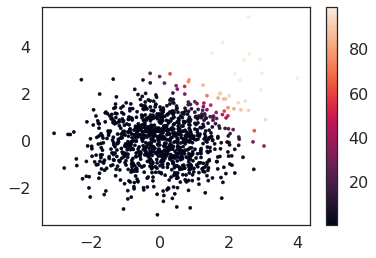

In [99]:
plt.scatter(X[:,0].data.cpu().numpy(), X[:,1].data.cpu().numpy(), s=10, c=true_ratios_source.data.cpu().numpy())
plt.colorbar()

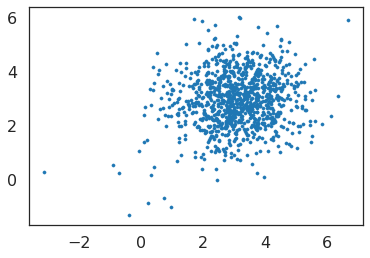

In [100]:
plt.scatter(Z[:,0].data.cpu().numpy(), Z[:,1].data.cpu().numpy(), s=10)

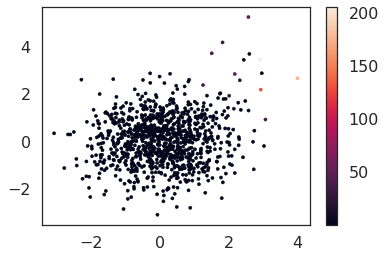

In [101]:
plt.scatter(X[:,0].data.cpu().numpy(), X[:,1].data.cpu().numpy(), s=10, c=x_weights_trials[idx])
plt.colorbar()

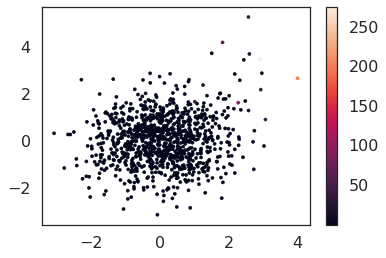

In [102]:
plt.scatter(X[:,0].data.cpu().numpy(), X[:,1].data.cpu().numpy(), s=10, c=z_weights_trials[idx])
plt.colorbar()

In [ ]:
est_ratios = torch.exp(0.99 * (q.log_prob(X).sum(-1) - 0.01 * p.log_prob(X).sum(-1)))

# Compiled classifier results:
#### Naive baseline
Test error on Z:  0.2452, Std: 0.04587 \
Test error on Z_test (unseen):  0.233, Std: 0.05088
#### X-DRE (sigma=0.5, B=1000)
Test error on Z:  0.137, Std:  0.04793 \
Test error on Z_test (unseen):  0.1268 Std:  0.04289
#### Z-DRE (sigma=1.0, B=1000)
Test error on Z:  0.0508 Std:  0.05636 \
Test error on Z_test (unseen):  0.0506 Std:  0.05498

In [57]:
kliep_naive = [0.221, 0.171, 0.204, 0.247, 0.322, 0.284, 0.265, 0.17, 0.226, 0.25]
kliep_x = [0.149, 0.13, 0.1, 0.155, 0.215, 0.299, 0.151, 0.118, 0.13, 0.178]
kliep_z = [0.13, 0.131, 0.155, 0.144, 0.084, 0.116, 0.103, 0.096, 0.115, 0.177]

No handles with labels found to put in legend.


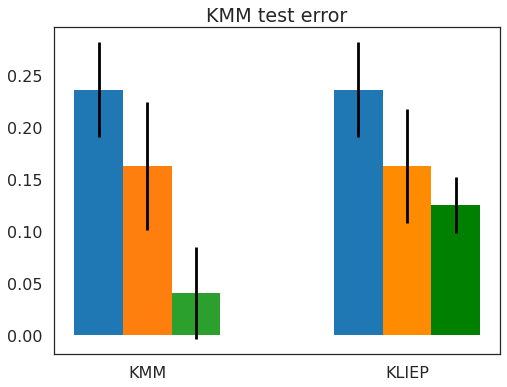

In [71]:
width = 0.05
plt.figure(figsize=(8,6))
plt.bar(width, np.mean(naive_err_unseens), width, yerr=np.std(naive_err_unseens))
plt.bar(2*width, np.mean(best_x_unseen_errs), width, yerr=np.std(best_x_unseen_errs))
plt.bar(3*width, np.mean(best_z_unseen_errs), width, yerr=np.std(best_z_unseen_errs))

plt.bar(1/6 + 3*width, np.mean(kliep_naive), width, yerr=np.std(kliep_naive), color='C0')
plt.bar(1/6 + 4*width, np.mean(kliep_x), width, yerr=np.std(kliep_x), color='darkorange')
plt.bar(1/6 + 5*width, np.mean(kliep_z), width, yerr=np.std(kliep_z), color='green')

# plt.bar(np.arange(3), [avg_naive_err_unseen, np.mean(best_x_unseen_errs), np.mean(best_z_unseen_errs)],  width#, label='naive')
# plt.bar(np.arange(3),  np.mean(best_x_unseen_errs), width, label='x-dre')
# plt.bar(1 + 2*width,  np.mean(best_z_unseen_errs), width, label='z-dre')
# plt.errorbar(1, avg_naive_err_unseen, yerr=np.std(naive_err_unseens), ecolor='black', fmt='none', label='std err')
# plt.errorbar(1 + width, np.mean(best_x_unseen_errs), yerr=np.std(best_x_unseen_errs), ecolor='black', fmt='none')
# plt.errorbar(1 + 2*width, np.mean(best_z_unseen_errs),  yerr=np.std(best_z_unseen_errs), ecolor='black', fmt='none')
plt.xticks([2*width, 1/6 + 4*width], ['KMM', 'KLIEP'])
plt.title('KMM test error')
plt.legend()
plt.show()

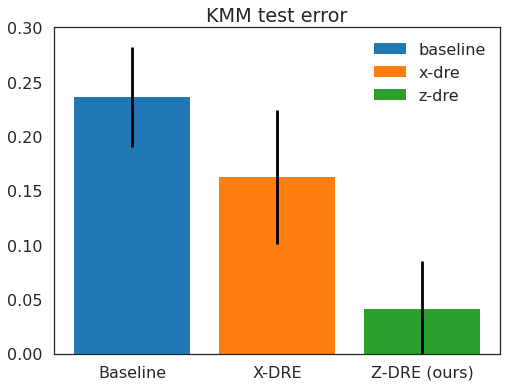

In [55]:
width = 0.2
plt.figure(figsize=(8,6))
plt.bar(0, avg_naive_err_unseen,yerr=np.std(naive_err_unseens), label='baseline')
        
#         np.mean(best_x_unseen_errs), np.mean(best_z_unseen_errs))#,  width)#, label='naive')
plt.bar(1,  np.mean(best_x_unseen_errs), yerr=np.std(best_x_unseen_errs), label='x-dre')
plt.bar(2,  np.mean(best_z_unseen_errs), yerr=np.std(best_z_unseen_errs), label='z-dre')
# plt.errorbar(0, avg_naive_err_unseen, yerr=np.std(naive_err_unseens), ecolor='black', fmt='none', label='std err')
# plt.errorbar(1, np.mean(best_x_unseen_errs), yerr=np.std(best_x_unseen_errs), ecolor='black', fmt='none')
# plt.errorbar(2, np.mean(best_z_unseen_errs),  yerr=np.std(best_z_unseen_errs), ecolor='black', fmt='none')

plt.xticks(np.arange(3), ['Baseline', 'X-DRE', 'Z-DRE (ours)'])
plt.title('KMM test error')
plt.ylim(0, 0.30)
plt.legend()
plt.show()

# ================= OLD =================

In [11]:
clf = LogisticRegression()
clf.fit(X, y, sample_weight=weights)
pred_adapt = clf.predict(Z)

# Train a naive logistic regressor
lr = LogisticRegression().fit(X, y)

# Make predictions
pred_naive = lr.predict(Z)


# Compute error rates
print('Error naive: ' + str(np.mean(pred_naive != u, axis=0)))
print('Error adapt: ' + str(np.mean(pred_adapt != u, axis=0)))

Error naive: 0.297
Error adapt: 0.297


In [12]:
pred_adapt_test = clf.predict(Z_test)
pred_naive_test = lr.predict(Z_test)

# Compute error rates
print('Error naive: ' + str(np.mean(pred_naive_test != u_test, axis=0)))
print('Error adapt: ' + str(np.mean(pred_adapt_test != u_test, axis=0)))

Error naive: 0.286
Error adapt: 0.288


What about the flow?

In [13]:
cd ../multi-fairgen/src/

/atlas/u/kechoi/multi-fairgen/src


### train KMM on z

In [17]:
flow_x = flow_train_x.data.cpu().numpy()
flow_z = flow_test_x.data.cpu().numpy()

In [18]:
kmm = ImportanceWeightedClassifier(weight_estimator='kmm', bandwidth=0.01)
z_weights = kmm.iwe_kernel_mean_matching(flow_x, flow_z)

     pcost       dcost       gap    pres   dres
 0:  4.9904e+02 -3.2216e+04  3e+04  1e-15  1e+03
 1:  4.8935e+02 -3.1317e+03  4e+03  2e-15  1e+02
 2:  4.7045e+02  3.2334e+02  1e+02  2e-14  8e-14
 3:  4.6896e+02  4.6745e+02  2e+00  1e-15  8e-14
 4:  4.6891e+02  4.6889e+02  2e-02  5e-15  9e-14
 5:  4.6891e+02  4.6891e+02  2e-04  9e-15  1e-13
Optimal solution found.


In [19]:
# Train via KMM
# from sklearn.linear_model import LogisticRegressionCV
# clf = LogisticRegressionCV(cv=5, solver='lbfgs')
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X, y, sample_weight=(z_weights))
pred_adapt = clf.predict(Z)

# Compute error rates
print('Error adapt: ' + str(np.mean(pred_adapt != u, axis=0)))

Error adapt: 0.297


In [20]:
# target test
flow_test_real, _ = flow(torch.from_numpy(Z_test).float().cpu())
pred_adapt_test = clf.predict(Z_test)
print('Error adapt in z-space: ' + str(np.mean(pred_adapt_test != u_test, axis=0)))

Error adapt in z-space: 0.288


Target
- Error naive: 0.297
- Error adapt: 0.259

Target (test)
- Error naive: 0.286
- Error adapt: 0.247

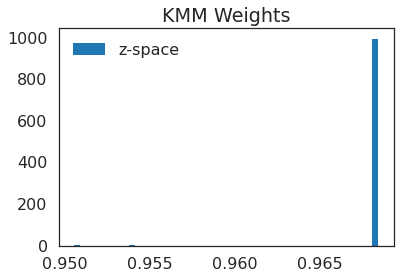

In [21]:
# _ = plt.hist(weights, bins=50, label='x-space')
_ = plt.hist(z_weights, bins=50, label='z-space')
# plt.yscale('log')

plt.title('KMM Weights')
plt.legend()
# 1/z_weights

---------

### What if I do the entire thing in z-space?

In [22]:
# Train via KMM
clf = LogisticRegression()
clf.fit(flow_x, y, sample_weight=z_weights)
pred_adapt = clf.predict(flow_z)

# Compute error rates
print('Error adapt: ' + str(np.mean(pred_adapt != u, axis=0)))

Error adapt: 0.638


In [24]:
# target test
flow_test_real, _ = flow(torch.from_numpy(Z_test).float().cpu())
pred_adapt_test = clf.predict(flow_test_real.data.cpu().numpy())
print('Error adapt in z-space: ' + str(np.mean(pred_adapt_test != u_test, axis=0)))

Error adapt in z-space: 0.629


----

### naive LR in z-space

In [25]:
lr = LogisticRegression()
lr.fit(flow_x, y)
pred_naive = lr.predict(flow_z)

# Compute error rates
print('Error naive in z-space: ' + str(np.mean(pred_naive != u, axis=0)))

Error naive in z-space: 0.635


In [26]:
# target test
flow_test_real, _ = flow(torch.from_numpy(Z_test).float().cpu())
pred_naive_test = lr.predict(flow_test_real.data.cpu().numpy())
print('Error naive (test) in z-space: ' + str(np.mean(pred_naive_test != u_test, axis=0)))

Error naive (test) in z-space: 0.629


---

# Weights

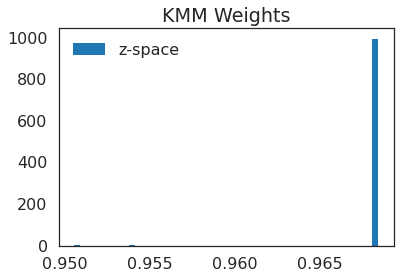

In [27]:
# _ = plt.hist(weights, bins=50, label='x-space')
_ = plt.hist(z_weights, bins=50, label='z-space')
# plt.yscale('log')

plt.title('KMM Weights')
plt.legend()

# Sanity check: different KMM repo

In [38]:
def kmm(Xtrain, Xtest, sigma=0.5):
    n_tr = len(Xtrain)
    n_te = len(Xtest)

    # calculate Kernel
    print('Computing kernel for training data ...')
    K_ns = sk.rbf_kernel(Xtrain, Xtrain, sigma)
    # make it symmetric
    K = 0.9 * (K_ns + K_ns.transpose())

    # calculate kappa
    print('Computing kernel for kappa ...')
    kappa_r = sk.rbf_kernel(Xtrain, Xtest, sigma)
    ones = np.ones(shape=(n_te, 1))
    kappa = np.dot(kappa_r, ones)
    kappa = -(float(n_tr) / float(n_te)) * kappa

    # calculate eps
    eps = (math.sqrt(n_tr) - 1) / math.sqrt(n_tr)

    # constraints
    A0 = np.ones(shape=(1, n_tr))
    A1 = -np.ones(shape=(1, n_tr))
    A = np.vstack([A0, A1, -np.eye(n_tr), np.eye(n_tr)])
    b = np.array([[n_tr * (eps + 1), n_tr * (eps - 1)]])
    b = np.vstack([b.T, -np.zeros(shape=(n_tr, 1)), np.ones(shape=(n_tr, 1)) * 1000])

    print('Solving quadratic program for beta ...')
    P = matrix(K, tc='d')
    q = matrix(kappa, tc='d')
    G = matrix(A, tc='d')
    h = matrix(b, tc='d')
    beta = solvers.qp(P, q, G, h)
    return [i for i in beta['x']]

In [78]:
def kernel_mean_matching(X, Z, kern='rbf', sigma=0.1, B=1, eps=None):
    nx = X.shape[0]
    nz = Z.shape[0]
    eps = (np.sqrt(nx) - 1)/np.sqrt(nx)
    if eps == None:
        eps = B/math.sqrt(nz)
    if kern == 'lin':
        K = np.dot(Z, Z.T)
        kappa = np.sum(np.dot(Z, X.T)*float(nz)/float(nx),axis=1)
    elif kern == 'rbf':
        K = compute_rbf(Z,Z)
        kappa = np.sum(compute_rbf(Z,X,sigma=sigma),axis=1)*float(nz)/float(nx)
    else:
        raise ValueError('unknown kernel')
        
    K = matrix(K)
    kappa = matrix(kappa)
    G = matrix(np.r_[np.ones((1,nz)), -np.ones((1,nz)), np.eye(nz), -np.eye(nz)])
    h = matrix(np.r_[nz*(1+eps), nz*(eps-1), B*np.ones((nz,)), np.zeros((nz,))])
    
    sol = solvers.qp(K, -kappa, G, h)
    coef = np.array(sol['x'])
    return coef

def compute_rbf(X, Z, sigma=0.1):
    K = np.zeros((X.shape[0], Z.shape[0]), dtype=float)
    for i, vx in enumerate(X):
        K[i,:] = np.exp(-np.sum((vx-Z)**2, axis=1)/(2.0*sigma))
    return K

In [79]:
bandwidths = [0.0025, 0.005, 0.01, 0.05, 0.1, 0.15, 0.25, 0.5, 0.75, 1.0]
# bandwidths = [0.1]

In [80]:
min_bandwidth_z = 0.01
min_adapt_error_z = float('inf')
min_weights_z = None
# for bandwidth in bandwidths:
#     kmm = ImportanceWeightedClassifier(weight_estimator='kmm', bandwidth=(bandwidth/np.sqrt(2)))
#     weights = kmm.iwe_kernel_mean_matching(flow_x, flow_z)
#     weights = kmm(flow_x.astype('float64'), flow_z.astype('float64'), sigma=bandwidth)
weights = kernel_mean_matching(flow_x.astype('float64'), flow_z.astype('float64'), sigma=0.1).flatten()
clf = LogisticRegression()
clf.fit(X, y, sample_weight=weights)
pred_adapt = clf.predict(Z)

# Train a naive logistic regressor
lr = LogisticRegression().fit(X, y)

# Make predictions
pred_naive = lr.predict(Z)


# Compute error rates
print('Error naive: ' + str(np.mean(pred_naive != u, axis=0)))
print('Error adapt: ' + str(np.mean(pred_adapt != u, axis=0)))


pred_adapt_test = clf.predict(Z_test)
pred_naive_test = lr.predict(Z_test)
# Compute error rates
naive_error = np.mean(pred_naive_test != u_test, axis=0)
adapt_error = np.mean(pred_adapt_test != u_test, axis=0)
if adapt_error < min_adapt_error_z:
    min_bandwidth_z = bandwidth
    min_adapt_error_z = adapt_error
    min_weights_z = weights
#     print('Error naive: ' + str(naive_error))
#     print('Error adapt: ' + str(adapt_error))

     pcost       dcost       gap    pres   dres
 0: -1.5825e+04 -1.0044e+06  7e+07  8e-01  2e-13
 1: -2.6895e+02 -9.9882e+05  2e+06  1e-02  2e-14
 2:  1.3329e+03 -3.0966e+05  3e+05  4e-16  7e-15
 3:  2.0242e+02 -5.2657e+04  5e+04  1e-15  3e-15
 4: -2.7982e+03 -1.2240e+04  9e+03  5e-16  2e-15
 5: -4.6447e+03 -6.6780e+03  2e+03  4e-16  9e-16
 6: -5.1646e+03 -5.8407e+03  7e+02  6e-16  7e-16
 7: -5.3076e+03 -5.6277e+03  3e+02  2e-15  5e-16
 8: -5.3954e+03 -5.4836e+03  9e+01  6e-17  5e-16
 9: -5.4231e+03 -5.4422e+03  2e+01  8e-16  6e-16
10: -5.4274e+03 -5.4357e+03  8e+00  9e-16  5e-16
11: -5.4297e+03 -5.4322e+03  3e+00  5e-16  5e-16
12: -5.4298e+03 -5.4319e+03  2e+00  2e-16  4e-16
13: -5.4305e+03 -5.4310e+03  5e-01  8e-16  7e-16
14: -5.4306e+03 -5.4309e+03  2e-01  1e-15  5e-16
15: -5.4307e+03 -5.4308e+03  7e-02  1e-15  6e-16
16: -5.4307e+03 -5.4307e+03  1e-02  4e-16  7e-16
17: -5.4307e+03 -5.4307e+03  3e-04  2e-15  8e-16
Optimal solution found.
Error naive: 0.297
Error adapt: 0.661


In [81]:
min_bandwidth = 0.01
min_adapt_error = float('inf')
min_weights = None
# for bandwidth in bandwidths:
kmm = ImportanceWeightedClassifier(weight_estimator='kmm', bandwidth=100)
weights = kmm.iwe_kernel_mean_matching(X, Z)
#     weights = kmm(X, Z, sigma=(1/(bandwidth ** 2)))

clf = LogisticRegression()
clf.fit(X, y, sample_weight=weights)
pred_adapt = clf.predict(Z)

# Train a naive logistic regressor
lr = LogisticRegression().fit(X, y)

# Make predictions
pred_naive = lr.predict(Z)


# Compute error rates
print('Error naive: ' + str(np.mean(pred_naive != u, axis=0)))
print('Error adapt: ' + str(np.mean(pred_adapt != u, axis=0)))


pred_adapt_test = clf.predict(Z_test)
pred_naive_test = lr.predict(Z_test)
# Compute error rates
naive_error = np.mean(pred_naive_test != u_test, axis=0)
adapt_error = np.mean(pred_adapt_test != u_test, axis=0)
if adapt_error < min_adapt_error:
    min_bandwidth = bandwidth
    min_adapt_error = adapt_error
    min_weights = weights
#     print('Error naive: ' + str(naive_error))
#     print('Error adapt: ' + str(adapt_error))

     pcost       dcost       gap    pres   dres
 0:  3.8877e+05  1.0025e+06  4e+08  1e+01  7e-01
 1:  1.4264e+06  7.6212e+05  4e+06  1e-01  6e-03
 2:  1.4370e+06  9.4750e+05  5e+05  7e-17  8e-13
 3:  1.4370e+06  1.4287e+06  8e+03  1e-15  1e-15
 4:  1.4370e+06  1.4367e+06  3e+02  5e-16  1e-13
 5:  1.4370e+06  1.4367e+06  2e+02  1e-15  5e-11
 6:  1.4370e+06  1.4367e+06  2e+02  6e-16  1e-09
 7:  1.4369e+06  1.4368e+06  1e+02  1e-16  3e-09
 8:  1.4369e+06  1.4368e+06  1e+02  8e-16  9e-09
 9:  1.4369e+06  1.4368e+06  3e+01  2e-15  8e-09
10:  1.4369e+06  1.4368e+06  4e+01  9e-17  1e-08
11:  1.4368e+06  1.4368e+06  1e+01  1e-15  8e-09
12:  1.4368e+06  1.4368e+06  1e+01  1e-15  4e-08
13:  1.4368e+06  1.4368e+06  1e+00  7e-16  5e-08
Optimal solution found.
Error naive: 0.297
Error adapt: 0.144


In [42]:
print('min adapt error X-space: ', min_adapt_error)
print('corresponding bandwidth: ', min_bandwidth)

min adapt error X-space:  0.153
corresponding bandwidth:  0.1


In [72]:
print('min adapt error Z-space: ', min_adapt_error_z)
print('corresponding bandwidth: ', min_bandwidth_z)

min adapt error Z-space:  0.289
corresponding bandwidth:  0.0025


In [5]:
_ = plt.hist(min_weights, bins=50, label='x-space')
# _ = plt.hist(z_weights_2, bins=50, label='z-space')
# plt.yscale('log')

plt.title('KMM Weights')
plt.legend()

NameError: name 'plt' is not defined

In [6]:
_ = plt.hist(min_weights_z, bins=50, label='z-space', color='darkorange')
# _ = plt.hist(z_weights_2, bins=50, label='z-space')
# plt.yscale('log')

plt.title('KMM Weights')
plt.legend()

NameError: name 'plt' is not defined

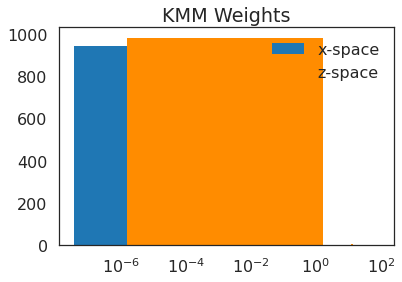

In [41]:
_ = plt.hist(min_weights, bins=50, label='x-space')
_ = plt.hist(min_weights_z, bins=50, label='z-space', color='darkorange')
plt.xscale('log')

plt.title('KMM Weights')
plt.legend()

In [ ]:
min_weights_z